In [2]:
#Import Libraries
import os.path
from os import path       
import requests
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
from shapely.geometry import Point, Polygon
from geopandas import GeoSeries
import dask

In [16]:
#Shape file bounds
basin_shape_file_path='../shape_file/HUC8-17030003_gcs.shp'
shape_file=gpd.read_file(basin_shape_file_path) # import basin boundary (Shape file in CRS: EPSG:4326)

#bounding box for data downloading
resolution=0.1   #Resolution of IMERG data
min_lat, max_lat, min_lon, max_lon = shape_file.bounds.miny[0]-resolution/2, shape_file.bounds.maxy[0]+resolution/2, shape_file.bounds.minx[0]-resolution/2, shape_file.bounds.maxx[0]+resolution/2
print(min_lon, min_lat, max_lon, max_lat)

-121.26903696684327 45.93282389319888 -119.15510656613446 46.696448636806146


<AxesSubplot:>

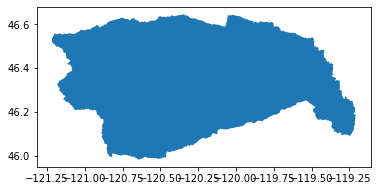

In [21]:
shape_file.plot()

#Download url list for Imerg rainfall data
https://disc.gsfc.nasa.gov/datasets/GPM_3IMERGDF_06/summary?keywords=imerg

workflow:
1. download data url list from above link using the bounding box of the catcment boundary
2. configure earthdata account using "uid" and "password"
3. set current directory where data is to be stored
4. download the data using url list ("url.txt")

In [ ]:
%%bash
cd ~
touch .netrc
echo "machine urs.earthdata.nasa.gov login <uid> password <password>" >> .netrc  #make sure to enter <uid> and <password>
chmod 0600 .netrc
cd ~
touch .urs_cookies
#change current directory to path where data is to be stored
cd ./RF_data_download/data1/    #make sure to create directory
wget --load-cookies ~/.urs_cookies --save-cookies ~/.urs_cookies --auth-no-challenge=on --keep-session-cookies --content-disposition -i ../modified.txt     #make sure to enter url list file name with absolute or relative path

In [3]:
#Preparation of the data
RF_data=xr.open_mfdataset('../data/*.nc4')
RF_data['precipitationCal'].to_netcdf('Combined_IMERG_daily_RF_Data.nc')
RF_data=xr.open_dataarray('Combined_IMERG_daily_RF_Data.nc')
RF_data

<xarray.DataArray 'precipitationCal' (time: 1947, lon: 21, lat: 8)>
[327096 values with dtype=float32]
Coordinates:
  * lon      (lon) float32 -121.25 -121.149994 ... -119.34999 -119.25
  * lat      (lat) float32 45.95001 46.05 46.150005 ... 46.45001 46.55 46.650005
  * time     (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2020-04-30
Attributes:
    long_name:  Daily accumulated precipitation (combined microwave-IR) estimate
    units:      mm

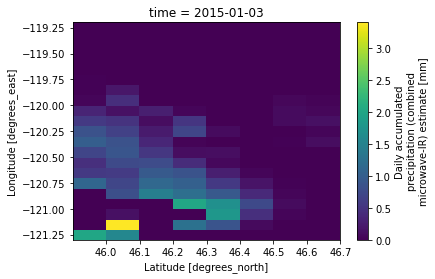

In [5]:
#Plot the daily data
%matplotlib inline
RF_data[3,:,:].plot()

In [14]:
#daily to monthly data
RF_monthly_data=RF_data.resample(time='1M').sum('time')
RF_monthly_data.to_netcdf('Combined_IMERG_monthly_RF_Data.nc')
RF_monthly_data

<xarray.DataArray 'precipitationCal' (time: 64, lon: 21, lat: 8)>
array([[[152.67856  , 158.92291  , 161.26183  , ..., 170.22191  ,
         181.18929  , 179.23816  ],
        [134.95476  , 143.91034  , 142.48962  , ..., 158.88293  ,
         154.97812  , 162.43163  ],
        [119.43188  , 128.4      , 125.673874 , ..., 137.30113  ,
         140.6947   , 147.98323  ],
        ...,
        [ 37.826344 ,  34.976364 ,  36.682003 , ...,  46.297203 ,
          39.947094 ,  35.866234 ],
        [ 41.30408  ,  50.681805 ,  39.549767 , ...,  49.284374 ,
          44.835445 ,  38.631218 ],
        [ 48.402966 ,  42.60701  ,  40.139965 , ...,  60.20815  ,
          55.60388  ,  45.579273 ]],

       [[130.51062  , 135.21706  , 138.80002  , ..., 145.77312  ,
         148.01106  , 150.65758  ],
        [118.624344 , 123.099754 , 124.49427  , ..., 131.69916  ,
         134.91283  , 136.30334  ],
        [107.334    , 110.530914 , 111.59831  , ..., 116.7048   ,
         119.22498  , 119.89867  ],
...
        [ 39.373928 ,  27.985437 ,  21.199654 , ...,  15.761783 ,
          14.071654 ,  12.779988 ],
        [ 41.117825 ,  27.238132 ,  28.957912 , ...,  20.003513 ,
          14.547997 ,  12.660483 ],
        [ 36.271873 ,  37.975388 ,  31.699854 , ...,  22.235306 ,
          16.36756  ,  13.707028 ]],

       [[ 11.388767 ,  20.849928 ,  31.780714 , ...,  39.66398  ,
          42.276848 ,  46.080925 ],
        [  9.483661 ,  12.871451 ,  22.261578 , ...,  46.471043 ,
          42.447433 ,  31.501635 ],
        [  7.8774815,  17.634768 ,  25.302204 , ...,  35.66323  ,
          36.766    ,  31.16163  ],
        ...,
        [ 15.0467415,   7.796214 ,   5.760611 , ...,   3.9390297,
           4.3506794,   4.028566 ],
        [ 14.707224 ,   7.4020534,   5.998911 , ...,   3.8886518,
           4.5077753,   4.787876 ],
        [ 15.803141 ,   9.249519 ,   8.029767 , ...,   4.6063747,
           5.7738247,   6.313079 ]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2015-01-31 2015-02-28 ... 2020-04-30
  * lon      (lon) float32 -121.25 -121.149994 ... -119.34999 -119.25
  * lat      (lat) float32 45.95001 46.05 46.150005 ... 46.45001 46.55 46.650005

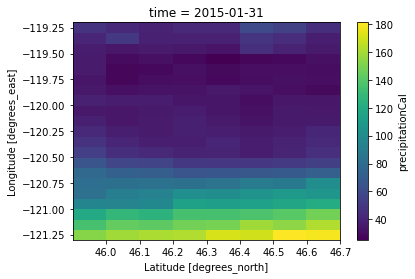

In [15]:
#Plot the monthly data
%matplotlib inline
RF_monthly_data[0,:,:].plot()

In [36]:
#import Dataset

whole_data=xr.open_dataarray('Combined_IMERG_monthly_RF_Data.nc')

#Get Data Spatial Resolution
resolution=(abs(whole_data[0,0,0].lat-whole_data[1,1,1].lat)).values
print(resolution)

sliced_data=whole_data.copy()   #
print("shape of the sliced data is", sliced_data.shape)
print(sliced_data)
shape=sliced_data.shape

########################################Extract data within a Shape file#######################
for i in range (shape[1]):
    for j in range (shape[2]):
        
        lon_cent, lat_cent = sliced_data[0, i, j].lon.values, sliced_data[0, i, j].lat.values
        
        lon1, lat1 = lon_cent-resolution/2, lat_cent-resolution/2
        lon2, lat2 = lon_cent-resolution/2, lat_cent+resolution/2
        lon3, lat3 = lon_cent+resolution/2, lat_cent-resolution/2
        lon4, lat4 = lon_cent+resolution/2, lat_cent+resolution/2
        
        grid_poly = gpd.GeoDataFrame({'geometry': GeoSeries(Polygon([(lon1, lat1), (lon3, lat3),  (lon4, lat4), (lon2, lat2)]))})
        
        try:
            intersect_poly = gpd.overlay(shape_file, grid_poly, how='intersection')
            if len(intersect_poly)==0:
                sliced_data[:, i, j]=np.nan
        except:
            sliced_data[:, i, j]=np.nan
            continue
            
sliced_data.to_netcdf('Combined_IMERG_monthly_RF_Data_catchment.nc')

0.099990845
shape of the sliced data is (64, 21, 8)
<xarray.DataArray 'precipitationCal' (time: 64, lon: 21, lat: 8)>
array([[[152.67856  , 158.92291  , 161.26183  , ..., 170.22191  ,
         181.18929  , 179.23816  ],
        [134.95476  , 143.91034  , 142.48962  , ..., 158.88293  ,
         154.97812  , 162.43163  ],
        [119.43188  , 128.4      , 125.673874 , ..., 137.30113  ,
         140.6947   , 147.98323  ],
        ...,
        [ 37.826344 ,  34.976364 ,  36.682003 , ...,  46.297203 ,
          39.947094 ,  35.866234 ],
        [ 41.30408  ,  50.681805 ,  39.549767 , ...,  49.284374 ,
          44.835445 ,  38.631218 ],
        [ 48.402966 ,  42.60701  ,  40.139965 , ...,  60.20815  ,
          55.60388  ,  45.579273 ]],

       [[130.51062  , 135.21706  , 138.80002  , ..., 145.77312  ,
         148.01106  , 150.65758  ],
        [118.624344 , 123.099754 , 124.49427  , ..., 131.69916  ,
         134.91283  , 136.30334  ],
        [107.334    , 110.530914 , 111.59831  , ...

/opt/conda/envs/whw/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

/opt/conda/envs/whw/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

/opt/conda/envs/whw/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

/opt/conda/envs/whw/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: CRS mismatch between the CRS of le

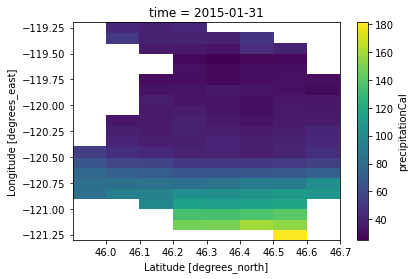

In [43]:
#Plot the monthly data for shp
%matplotlib inline
sliced_data[0,:,:].plot()